In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import VotingRegressor, StackingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
vaccine_data = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240111.csv')
death_data = pd.read_csv('data/deaths_with_abbs.csv')
data1 = pd.read_csv('data/covid_deaths2.csv')
data = pd.read_csv('data/merged_clean.csv')
data 

,date.x,state,location,year,month.x,mmwr_week,covid_19_deaths,date.y,distributed,distributed_janssen,...,bivalent_booster_12plus_pop_pct,bivalent_booster_18plus,bivalent_booster_18plus_pop_pct,bivalent_booster_65plus,bivalent_booster_65plus_pop_pct,month.y,day_of_week,region,month,season
0,2020-01-04,Alabama,AL,2020,1,1,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
1,2020-01-11,Alabama,AL,2020,1,2,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
2,2020-01-18,Alabama,AL,2020,1,3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
3,2020-01-25,Alabama,AL,2020,1,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
4,2020-02-01,Alabama,AL,2020,2,5,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,2,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10915,2023-12-09,Puerto Rico,PR,2023,12,49,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10916,2023-12-16,Puerto Rico,PR,2023,12,50,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10917,2023-12-23,Puerto Rico,PR,2023,12,51,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10918,2023-12-30,Puerto Rico,PR,2023,12,52,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter


# Dropping Data

In [4]:
data = data.drop(['date.y', 'month.x', 'state','month.y', 'day_of_week'], axis=1) 
data = data.dropna(subset=['covid_19_deaths'])  

In [5]:
data 

,date.x,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,bivalent_booster_5plus_pop_pct,bivalent_booster_12plus,bivalent_booster_12plus_pop_pct,bivalent_booster_18plus,bivalent_booster_18plus_pop_pct,bivalent_booster_65plus,bivalent_booster_65plus_pop_pct,region,month,season
0,2020-01-04,AL,2020,1,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
1,2020-01-11,AL,2020,2,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
2,2020-01-18,AL,2020,3,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
4,2020-02-01,AL,2020,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,2,Winter
5,2020-02-08,AL,2020,6,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,2,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10910,2023-11-04,PR,2023,44,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,11,Fall
10911,2023-11-11,PR,2023,45,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,11,Fall
10914,2023-12-02,PR,2023,48,13.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10916,2023-12-16,PR,2023,50,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter


In [6]:
data = pd.read_csv('data/merged_cleaned_processed.csv')
data

,Unnamed: 0,date,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,...,month,region_East,region_Midwest,region_Puerto Rico,region_South,region_West,season_Fall,season_Spring,season_Summer,season_Winter
0,0,2020-01-04,AL,2020,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
1,1,2020-01-04,LA,2020,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
2,2,2020-01-04,VA,2020,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
3,3,2020-01-04,KY,2020,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
4,4,2020-01-04,KS,2020,1,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8944,8944,2024-01-06,OH,2024,1,23.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1
8945,8945,2024-01-06,NY,2024,1,145.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,1
8946,8946,2024-01-06,NJ,2024,1,39.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,1
8947,8947,2024-01-06,NH,2024,1,12.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,1


# Univariate Analysis

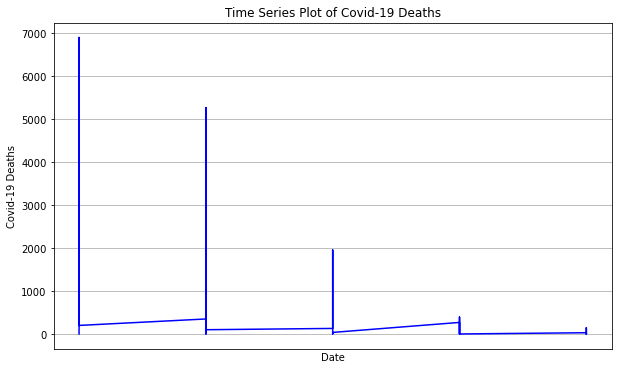

Descriptive Statistics:
count    8949.000000
mean      130.334674
std       284.628426
min         0.000000
25%        21.000000
50%        48.000000
75%       123.000000
max      6900.000000
Name: covid_19_deaths, dtype: float64


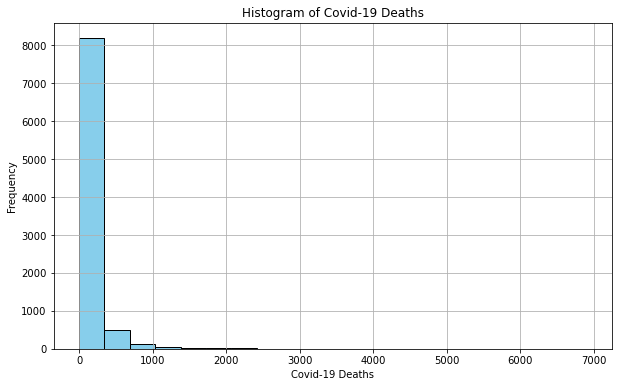

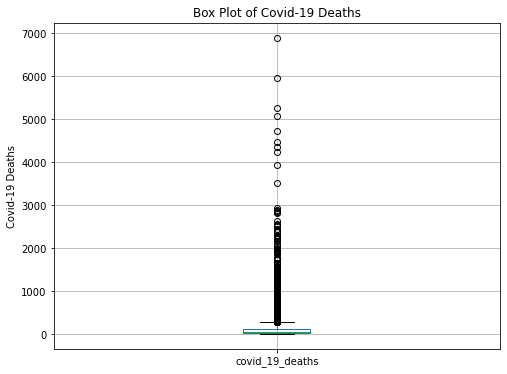

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' contains your dataset with a DateTime index and a column named 'covid_19_deaths'
data.index = pd.to_datetime(data.index)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data['covid_19_deaths'], color='blue')
plt.title('Time Series Plot of Covid-19 Deaths')
plt.xlabel('Date')
plt.ylabel('Covid-19 Deaths')
plt.grid(True)
plt.show()

# Descriptive statistics
print("Descriptive Statistics:")
print(data['covid_19_deaths'].describe())

# Distribution plot
plt.figure(figsize=(10, 6))
plt.hist(data['covid_19_deaths'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Covid-19 Deaths')
plt.xlabel('Covid-19 Deaths')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Box plot
plt.figure(figsize=(8, 6))
data.boxplot(column='covid_19_deaths')
plt.title('Box Plot of Covid-19 Deaths')
plt.ylabel('Covid-19 Deaths')
plt.grid(True)
plt.show()


#  Correlation

In [158]:
correlations = data.corrwith(data["covid_19_deaths"])
correlations_df = pd.DataFrame({'feature': correlations.index, 'correlation': correlations.values})
correlations_df.sort_values(by = ['correlation'], ascending = False)

,feature,correlation
3,covid_19_deaths,1.000000
74,additional_doses_5plus,0.626565
91,second_booster_65plus,0.607488
89,second_booster_50plus,0.585957
93,second_booster_janssen,0.568839
...,...,...
28,admin_per_100k_18plus,-0.247874
40,administered_dose1_recip_65plus_pop_pct,-0.261466
50,series_complete_65plus_pop_pct,-0.265322
29,admin_per_100k_65plus,-0.273770


In [159]:
# Remove constant features
constant_features = data.columns[data.nunique() == 1]
print(constant_features)

Index([], dtype='object')


In [160]:
#remove redundant features
corr_matrix = data.corr().abs()
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
correlated_columns = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.5)]

In [161]:
correlated_columns

['Unnamed: 0',
 'year',
 'mmwr_week',
 'covid_19_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_dose1_re

In [162]:
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                 Unnamed: 0      year  mmwr_week  covid_19_deaths  \
Unnamed: 0         1.000000  0.966267   0.204008         0.159714   
year               0.966267  1.000000   0.033363         0.159780   
mmwr_week          0.204008  0.033363   1.000000         0.003123   
covid_19_deaths    0.159714  0.159780   0.003123         1.000000   
distributed        0.307053  0.303141   0.038266         0.134438   
...                     ...       ...        ...              ...   
region_West        0.032899  0.035354   0.004936         0.039212   
season_Fall        0.130887  0.013964   0.555491         0.015092   
season_Spring      0.085963  0.006384   0.403033         0.057323   
season_Summer      0.014082  0.035391   0.065263         0.070978   
season_Winter      0.032949  0.040073   0.218917         0.133806   

                 distributed  distributed_janssen  distributed_moderna  \
Unnamed: 0          0.307053             0.267033             0.304942   
yea

In [163]:
correlation_matrix = data.corr()['covid_19_deaths']
print("Correlation Matrix with Target Variable:")
print(correlation_matrix)

Correlation Matrix with Target Variable:
Unnamed: 0        -0.159714
year              -0.159780
mmwr_week          0.003123
covid_19_deaths    1.000000
distributed        0.134438
                     ...   
region_West       -0.039212
season_Fall       -0.015092
season_Spring     -0.057323
season_Summer     -0.070978
season_Winter      0.133806
Name: covid_19_deaths, Length: 120, dtype: float64


<AxesSubplot:>

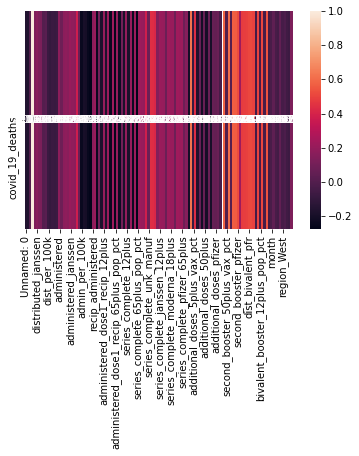

In [164]:
correlation_df = pd.DataFrame(correlation_matrix)
sns.heatmap(correlation_df.transpose(), annot=True)

# Lag + Rolling Mean 

In [165]:
import pandas as pd

data.sort_values(by='date', inplace=True)

# Lag features
num_lags = 3  # Number of lag features
for i in range(1, num_lags + 1):
    data[f'covid_19_deaths_lag_{i}'] = data['covid_19_deaths'].shift(i)

# Rolling statistics
window_size = 7  # Rolling window size
data['rolling_mean'] = data['covid_19_deaths'].rolling(window=window_size).mean()
data['rolling_std'] = data['covid_19_deaths'].rolling(window=window_size).std()

# Print the updated DataFrame to verify the changes
print(data) 

      Unnamed: 0        date location  year  mmwr_week  covid_19_deaths  \
0              0  2020-01-04       AL  2020          1              0.0   
28            28  2020-01-04       OR  2020          1              0.0   
29            29  2020-01-04       OK  2020          1              0.0   
30            30  2020-01-04       SC  2020          1              0.0   
31            31  2020-01-04       OH  2020          1              0.0   
...          ...         ...      ...   ...        ...              ...   
8926        8926  2024-01-06       DE  2024          1              0.0   
8927        8927  2024-01-06       CT  2024          1              0.0   
8928        8928  2024-01-06       CA  2024          1             48.0   
8930        8930  2024-01-06       AZ  2024          1             18.0   
8948        8948  2024-01-06       NV  2024          1              0.0   

      distributed  distributed_janssen  distributed_moderna  \
0             0.0                  0

In [166]:
import pandas as pd

# Sort the DataFrame by 'End Date' 
data.sort_values(by='date', inplace=True)

# Lag features
num_lags = 28  # Number of lag features
for i in range(1, num_lags + 1):
    data[f'covid_19_deaths_lag_{i}'] = data['covid_19_deaths'].shift(i)

# Rolling statistics
window_size = 7  # Rolling window size
data['rolling_mean'] = data['covid_19_deaths'].rolling(window=window_size).mean()
data['rolling_std'] = data['covid_19_deaths'].rolling(window=window_size).std()

# Print the updated DataFrame to verify the changes
print(data) 

      Unnamed: 0        date location  year  mmwr_week  covid_19_deaths  \
0              0  2020-01-04       AL  2020          1              0.0   
25            25  2020-01-04       MD  2020          1              0.0   
2              2  2020-01-04       VA  2020          1              0.0   
3              3  2020-01-04       KY  2020          1              0.0   
4              4  2020-01-04       KS  2020          1              0.0   
...          ...         ...      ...   ...        ...              ...   
8946        8946  2024-01-06       NJ  2024          1             39.0   
8932        8932  2024-01-06       GA  2024          1             17.0   
8939        8939  2024-01-06       SD  2024          1              0.0   
8922        8922  2024-01-06       IL  2024          1             41.0   
8948        8948  2024-01-06       NV  2024          1              0.0   

      distributed  distributed_janssen  distributed_moderna  \
0             0.0                  0

# Seasonality

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data['date'] = pd.to_datetime(data['date'])  # Assuming 'date' is the column name containing dates

# Set the 'date' column as the index of the DataFrame
data.set_index('date', inplace=True)

# Ensure that the index is a DateTimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    raise ValueError("Index is not a DateTimeIndex")

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['covid_19_deaths'], model='additive')

# Plot the decomposition
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(data['covid_19_deaths'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [168]:
# Find the non-binary categorical columns
cat_cols = []
for col in data.columns:
    if data[col].dtype == 'object' and len(data[col].unique()) > 2:
        cat_cols.append(col)
print("Non-binary categorical columns:", cat_cols)

# Create binary columns from the categorical columns
data = pd.get_dummies(data, columns=cat_cols)

# Print the resulting dataframe
print(data.head())

Non-binary categorical columns: ['location']
            Unnamed: 0  year  mmwr_week  covid_19_deaths  distributed  \
date                                                                    
2020-01-04           0  2020          1              0.0          0.0   
2020-01-04          25  2020          1              0.0          0.0   
2020-01-04           2  2020          1              0.0          0.0   
2020-01-04           3  2020          1              0.0          0.0   
2020-01-04           4  2020          1              0.0          0.0   

            distributed_janssen  distributed_moderna  distributed_pfizer  \
date                                                                       
2020-01-04                  0.0                  0.0                 0.0   
2020-01-04                  0.0                  0.0                 0.0   
2020-01-04                  0.0                  0.0                 0.0   
2020-01-04                  0.0                  0.0           

# Training the Data


In [169]:
#split the target value and the features
y= data['covid_19_deaths']
X= data.drop(['covid_19_deaths'], axis=1) 

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=45)

#scale the features
scaler = StandardScaler()

scaler.fit(X_train)
scaler.fit(X_test)
xscaler_train = scaler.fit_transform(X_train) 
xscaler_test = scaler.fit_transform(X_test)

# Linear Regression Model 

In [183]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

print(data.head())  # Print the first few rows of the DataFrame to check its structure

# Assuming 'data' contains your time series data with a column named 'date.x'
# If the column is named differently, adjust the column name accordingly
data['date'] = pd.to_datetime(data['date'])


# Set the 'date' column as the index of the DataFrame
data.set_index('date', inplace=True)

# Replace 'dependent_variable' and 'independent_variable' with your actual variable names
covid_19_deaths = 'covid_19_deaths'  # Replace with your actual dependent variable
date = 'date' 

# Assuming 'data' contains both the dependent and independent variables
data = data[[covid_19_deaths, date]]

# Add a constant term for the intercept
data = add_constant(data)

# Fit the linear regression model
model = OLS(data[covid_19_deaths], data[date])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data[year], label='Actual')
plt.plot(data.index, result.predict(data[covid_19_deaths]), label='Predicted')
plt.xlabel('date')
plt.ylabel('covid_19_deaths')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

                               Unnamed: 0  mmwr_week  covid_19_deaths  \
year                                                                    
1970-01-01 00:00:00.000002020           0          1              0.0   
1970-01-01 00:00:00.000002020          25          1              0.0   
1970-01-01 00:00:00.000002020           2          1              0.0   
1970-01-01 00:00:00.000002020           3          1              0.0   
1970-01-01 00:00:00.000002020           4          1              0.0   

                               distributed  distributed_janssen  \
year                                                              
1970-01-01 00:00:00.000002020          0.0                  0.0   
1970-01-01 00:00:00.000002020          0.0                  0.0   
1970-01-01 00:00:00.000002020          0.0                  0.0   
1970-01-01 00:00:00.000002020          0.0                  0.0   
1970-01-01 00:00:00.000002020          0.0                  0.0   

                  

KeyError: 'date'

# Logistic Regression Model

In [184]:
def initialize(dim):
    weights = np.full((dim,),0.01)
    bias = 0.0
    return weights, bias 

def predict(model_parameters, X_test, threshold=0.5):
    weights = model_parameters['weights']
    bias = model_parameters['bias']
    #predicted probabilities
    z = np.dot(X_test, weights) + bias
    y_prob = 1/(1+np.exp(-z))
    #predicted class labels
    y_pred = (y_prob>=threshold).astype(int)
    return y_pred

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [185]:
def calculate_cost_gradient(weights, bias, X_train, y_train):
    m = X_train.shape[0]
    # calculate predicted probabilities
    z = np.dot(X_train, weights) + bias
    y_prob = sigmoid(z)
    # calculate cost function
    cost = -1/m * np.sum(y_train.to_numpy().flatten()*np.log(y_prob) + (1-y_train.to_numpy().flatten())*np.log(1-y_prob))
    
    # calculate gradients
    #dw=derivative bias
    #dw=gradient weight
    dw = 1/m * np.dot(X_train.T, (y_prob - y_train.values))
    db = 1/m * np.sum(y_prob - y_train.values)
    
    return cost, dw, db

In [186]:
def GradientDescent(weights, bias, X_train, y_train, lr, iters, tol):
    # Initialize the parameters
    m = X_train.shape[0]
    costs = []
    # Create a dictionary to store the parameters
    parameters = {"weights": weights, "bias": bias}
    # Gradient Descent loop
    for i in range(iters):
        # Calculate the predicted probabilities
        z = np.dot(X_train, parameters["weights"]) + parameters["bias"]
        y_pred = sigmoid(z)
        # Calculate the error
        error = y_pred - y_train
        # Calculate the gradients
        dw = (1/m) * np.dot(X_train.T, error)
        db = (1/m) * np.sum(error)
        # Update the parameters
        parameters["weights"] -= lr * dw
        parameters["bias"] -= lr * db
        # Calculate the cost
        cost = (-1/m) * np.sum(y_train*np.log(y_pred) + (1-y_train)*np.log(1-y_pred))
        costs.append(cost)
        # Check if the cost has converged
        if i > 0 and np.abs(costs[-1] - costs[-2]) <= tol:
            break
    
    # Plot the cost vs. iteration graph
    index = np.arange(len(costs))
    plt.plot(index, costs)
    plt.xlabel('date')
    plt.ylabel('covid19 deaths')
    plt.show()
    
    return parameters, costs

In [187]:
def logistic_regression(X_train, y_train, X_test, y_test, lr, iters, tol, threshold):
    # Initialize weights and bias to zeros
    weights = np.zeros(X_train.shape[1])
    bias = 0
    # Call GradientDescent function
    optimum_parameters, costs = GradientDescent(weights, bias, X_train, y_train, lr, iters, tol)
    # Predict
    y_pred = predict(optimum_parameters, X_test, threshold)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Print the accuracy
    print('Test Accuracy:', accuracy)
    # Print the MAE
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    # Return optimum_parameters, costs, and accuracy
    return optimum_parameters, costs, accuracy

In [188]:
learning_rate = 0.1 
num_iterations = 1000
tol = 0.0000001
threshold = 0.5

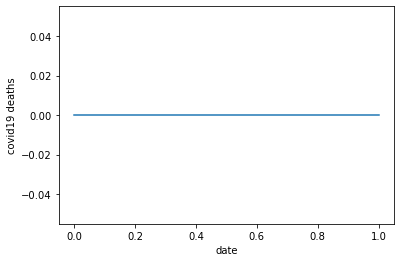

Test Accuracy: 0.06927374301675977
Mean Absolute Error: 138.50893854748603


({'weights': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan

In [189]:
optimum_parameters = logistic_regression(xscaler_train, y_train, xscaler_test, y_test, learning_rate, num_iterations, tol,threshold)
optimum_parameters

# Kmeans

# ARIMA

Mean Squared Error: 4506.898464872211


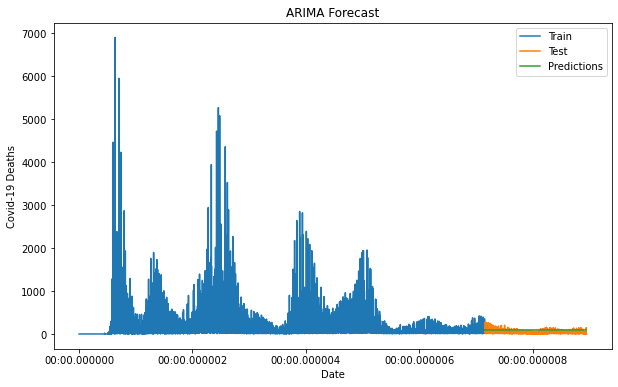

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming 'data' contains your dataset with a DateTime index and a column named 'covid_19_deaths'
# If not, replace 'covid_19_deaths' with the actual column name of your time series variable
# Ensure that the index is a DateTimeIndex
data.index = pd.to_datetime(data.index)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)  # 80% train, 20% test
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train_data['covid_19_deaths'], order=(5,1,0))  # Example order (p, d, q)
fitted_model = model.fit()

# Make predictions
predictions = fitted_model.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data['covid_19_deaths'], predictions)
print("Mean Squared Error:", mse)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['covid_19_deaths'], label='Train')
plt.plot(test_data.index, test_data['covid_19_deaths'], label='Test')
plt.plot(test_data.index, predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Covid-19 Deaths')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


# LSTM

In [10]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Epoch 1/100
224/224 [==============================] - 4s 7ms/step - loss: 0.0019 - val_loss: 4.3889e-05
Epoch 2/100
224/224 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 3.2586e-05
Epoch 3/100
224/224 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 2.9830e-05
Epoch 4/100
224/224 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 7.0419e-05
Epoch 5/100
224/224 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 3.6825e-05
Epoch 6/100
224/224 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 8.1356e-05
Epoch 7/100
224/224 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 2.5313e-05
Epoch 8/100
224/224 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 1.1631e-04
Epoch 9/100
224/224 [==============================] - 1s 6ms/step - loss: 0.0019 - val_loss: 1.5404e-04
Epoch 10/100
224/224 [==============================] -

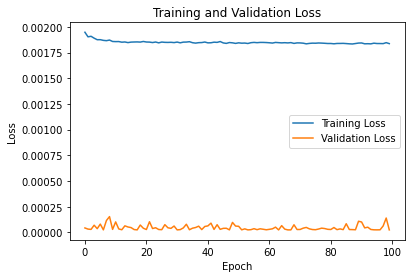

56/56 [==============================] - 0s 3ms/step


ValueError: x and y must have same first dimension, but have shapes (1780,) and (1790,)

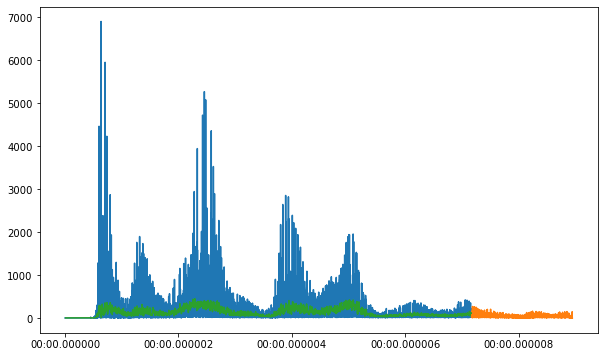

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming 'data' contains your dataset with a column named 'covid_19_deaths'
# If not, replace 'covid_19_deaths' with the actual column name of your time series variable
# Ensure that the index is a DateTimeIndex
data.index = pd.to_datetime(data.index)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['covid_19_deaths']])

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Define function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 10  # You can adjust this value based on the sequence length you want to consider

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Define and train the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(data.index[:len(train_data)], data['covid_19_deaths'][:len(train_data)], label='Train')
plt.plot(data.index[len(train_data)+seq_length:len(train_data)+seq_length+len(test_data)], data['covid_19_deaths'][len(train_data)+seq_length:len(train_data)+seq_length+len(test_data)], label='Test')
plt.plot(data.index[:len(train_data)], np.concatenate([np.full(seq_length, np.nan), train_predictions.flatten()]), label='Train Predictions')
plt.plot(data.index[len(train_data)+seq_length:], np.concatenate([np.full(seq_length, np.nan), test_predictions.flatten()]), label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Covid-19 Deaths')
plt.title('LSTM Forecast')
plt.legend()
plt.show()


# Stationary

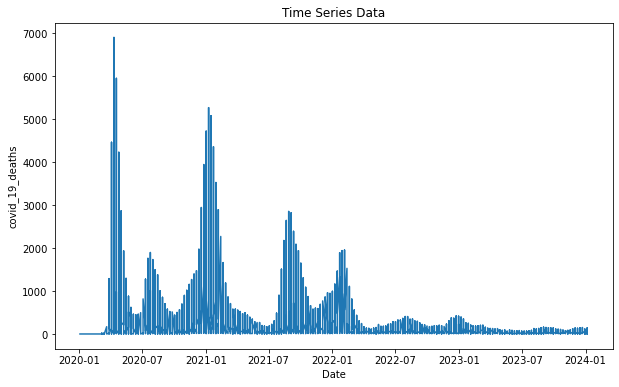

Mean: 130.33467426528102
Variance: 81013.34070748562
ADF Test p-value: 8.314055535026959e-05


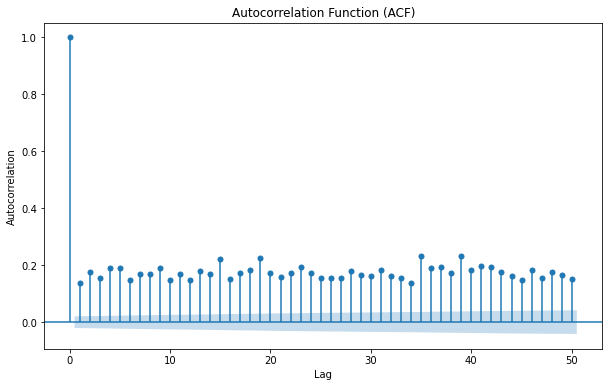

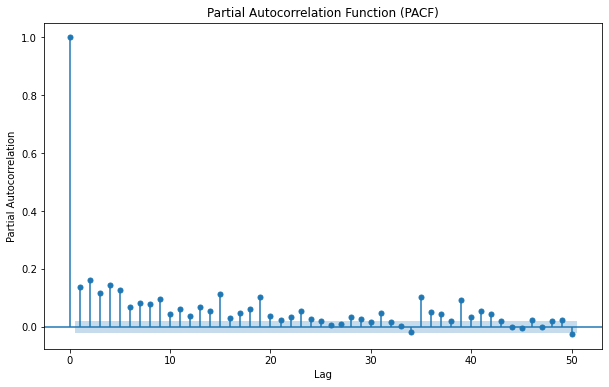

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'data' contains your time series data with a DateTime index
# If not, set the index to your DateTime column
# Replace 'covid_19_deaths' with the name of your target variable
ts = data['covid_19_deaths']

# 1. Visual Inspection
plt.figure(figsize=(10, 6))
plt.plot(ts)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('covid_19_deaths')
plt.show()

# 2. Summary Statistics
print("Mean:", ts.mean())
print("Variance:", ts.var())

# 3. Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(ts)
print("ADF Test p-value:", adf_result[1])

# 5. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
plt.figure(figsize=(10, 6))
plot_acf(ts, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(ts, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Prophet

14:12:51 - cmdstanpy - INFO - Chain [1] start processing
14:12:54 - cmdstanpy - INFO - Chain [1] done processing


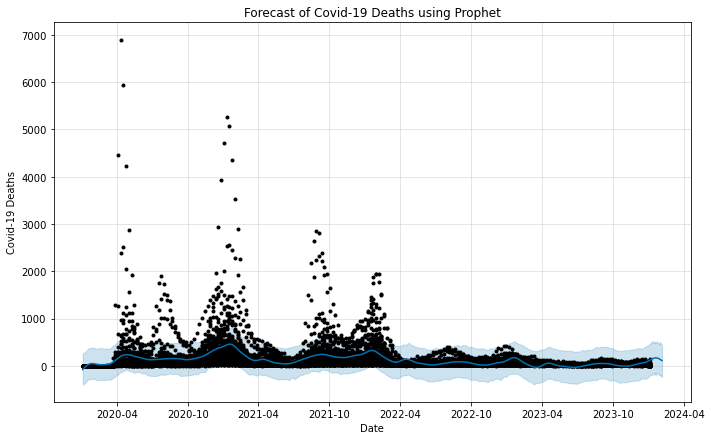

In [8]:
import pandas as pd
from prophet import Prophet

# Assuming 'data' contains your dataset with a DateTime index and a column named 'covid_19_deaths'
# If not, replace 'covid_19_deaths' with the actual column name of your time series variable
data_prophet = data.reset_index()  # Reset index to use 'ds' as the time column
data_prophet = data_prophet.rename(columns={'date': 'ds', 'covid_19_deaths': 'y'})  # Rename columns for Prophet

# Initialize Prophet model
model = Prophet()

# Fit the model to the data
model.fit(data_prophet)

# Define future dates for prediction
future_dates = model.make_future_dataframe(periods=30)  # Forecast for 30 days into the future

# Make predictions
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Covid-19 Deaths')
plt.title('Forecast of Covid-19 Deaths using Prophet')
plt.show()
